In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option("display.float_format", lambda x: f"{x:.5f}")
plt.style.use("ggplot")
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
sns.set_style("whitegrid")

# 读入清洗后的数据  
按时间划分数据集

In [2]:
file = "/Users/chen/Desktop/LendingClub/LC2017Q1_Q3_clean.csv"
data = pd.read_csv(file)


encoding_loan_status = {
    "Current": 0,
    "Fully Paid": 0,
    "Late (16-30 days)": 2,
    "Late (31-120 days)": 1,
    "In Grace Period": 2,
    "Default": 2,
    "Charged Off": 1,
}

data.replace(to_replace={"loan_status": encoding_loan_status}, inplace=True)
data = data[data["loan_status"]!=2]

months = ["Jan-2017", "Feb-2017", "Mar-2017", "Apr-2017", "May-2017", "Jun-2017"]
df_train = data.loc[data["issue_d"].isin(months)]
# 取反 ~
df_test = data.loc[~data["issue_d"].isin(months)]

# 定义函数  
包括卡方分箱、WOE编码、IV计算、KS计算和作图

In [3]:
def calc_chi2(df):
    """
    calculate chi2 of df

    df:                            a 2*3 dataframe, index_col is pd.Interval,
                                   total, bad, good
    df.sum() / df.sum()["total"]:  calculate expect_rate in each columns
    df["total"]:                   total sample number in each row
    np.newaxis for vectorization
    """
    expect = ( 
        (df.sum() / df.sum()["total"])[np.newaxis, :] * 
        np.array(df["total"])[:, np.newaxis]
    )
    
    return ((df - expect)**2 / expect).sum().sum()


def merge_class_br01(df, method="zero"):
    """
    merge bins if bad_rate is 0 or 1 in classified feature

    df: 
    method:  "zero" | "one", need merge bin when bad_rate is 0 or 1
    """
    max_or_min = ""
    value = 0
    if method == "zero":
        max_or_min = min
        value = 0
    elif method == "one":
        max_or_min = max
        value = 1
    else:
        print("method wrong! [zero|one]")

    max_or_min_bad_rate = max_or_min(df[df["bad_rate"]!=value]["bad_rate"])
    to_be_merged_df = df.loc[
        (df["bad_rate"]==value) | (df["bad_rate"]==max_or_min_bad_rate)
    ]
    to_be_merged_idx = to_be_merged_df.index
    merged_value = to_be_merged_df.sum()
    for i in to_be_merged_idx:
        df.loc[i] = merged_value

    return df


def concat_df(df_bin_grp, target_feature, bin_feature=None):
    """
    use pd.concat to concat 2 df
    """
    df = pd.DataFrame()
    if bin_feature is None:
        df = pd.concat([
                df_bin_grp.count().rename(columns={target_feature: "total"}),
                df_bin_grp.sum().rename(columns={target_feature: "bad"}),
            ],
            axis=1
        )
    else:
        df = pd.concat([
                df_bin_grp.count().drop(columns=bin_feature).rename(
                    columns={target_feature: "total"}),
                df_bin_grp.sum().drop(columns=bin_feature).rename(
                    columns={target_feature: "bad"}),
            ],
            axis=1
        )
    
    return df


def encoding_class_feature(df_bin, bin_feature, target_feature):
    """
    encode classified feature by bad_rate, merge bins if bad_rate is 0 or 1

    df_bin:          DataFrame with bin_feature and target_feature
    bin_feature:     to be binned feature name, it is a classified feature 
    target_feature:

    return:
        df
        br_encode_dict:  bad_rate encode dict, {"car": 0.013, "wedding": 0.01}
    """
    df_bin_grp = df_bin.groupby(bin_feature)
    df_code = concat_df(df_bin_grp, target_feature)
    df_code["bad_rate"] = df_code["bad"] / df_code["total"]

    if df_code["bad_rate"].min() == 0:
        df_code = merge_class_br01(df_code, method="zero")
    if df_code["bad_rate"].max() == 1:
        df_code = merge_class_br01(df_code, method="one")
        
    df_code["bad_rate"] = df_code["bad"] / df_code["total"]
    br_encode_dict = dict(zip(df_code.index, df_code["bad_rate"]))
    
    return df_bin.replace(to_replace=br_encode_dict), br_encode_dict


def merge_adjacent_2bins(df, idx, bin_feature):
    """
    merge adjacent up and down, 2 bins

    idx:  row number of the first bin
    """
    s = df[idx:idx+2].sum()
    iv1 = df.iloc[idx].name # interval_1
    iv2 = df.iloc[idx+1].name
    new_iv = pd.Interval(left=iv1.left, right=iv2.right, closed="right")
    s.rename(new_iv, inplace=True)

    df_merged_row = s.to_frame().T
    df_merged_row.index.rename(bin_feature, inplace=True)

    df = df.reset_index().drop(
        [idx, idx+1]
    )

    df_merged_row.reset_index(inplace=True)
    df = (df.append(df_merged_row)).set_index(
        bin_feature
    )
    
    return df.sort_index()


def is_monotonic(array):
    """
    judge whether an array-like object is monotonic

    return:
        monotone:  bool
        idx:       row number of first bin which should be merged

    """
    monotone = True
    n = len(array) - 1
    idx = -1
    increase_or_decrease = array[-1] - array[0]
    
    if increase_or_decrease > 0:
        for i in range(n):
            if array[i + 1] < array[i]:
                monotone = False
                idx = i
                break
    else:
        for i in range(n):
            if array[i + 1] > array[i]:
                monotone = False
                idx = i
                break
    
    return monotone, idx


def is_U_shaped(array):
    """
    judge whether an array-like object is U-shaped, can be U or inverse-U
    """
    is_U = False
    extremum_idx = [np.argmax(array), np.argmin(array)]
    for idx in extremum_idx:
        if (idx != 0 and idx != len(array)-1):
            is_U = is_monotonic(array[:idx])[0] and is_monotonic(array[idx:])[0]
            break
    return is_U


def merge_chi2_thresh(df, bin_feature, min_bin_num=5, conf_level=0.95):
    """
    merge bins according to chi2_thresh

    !!! maybe should IGNORE min_bin_num
    """
    chi2 = stats.chi2(df=1)
    chi2_thresh = chi2.ppf(q=conf_level)
    bin_num = df.index.nunique() # current bin number
    in_chi2_conf = True

    while (bin_num > min_bin_num) and in_chi2_conf:
        min_row_idx = 0
        min_chi2 = np.inf
        for i in range(len(df)-1):
            df_2row = df.iloc[i:i+2]
            chi2 = calc_chi2(df_2row)
            if chi2 < min_chi2:
                min_chi2 = chi2
                min_row_idx = i
        if min_chi2 <= chi2_thresh:
            in_chi2_conf = True
        else:
            in_chi2_conf = False
            print(f"min_chi2({min_chi2}) > chi2_thresh({chi2_thresh})")
            break
                
        df = merge_adjacent_2bins(df, min_row_idx, bin_feature)

        bin_num -=1
    return df


def merge_binned_br01(df, bin_feature):
    """
    merge bins if bad_rate of bin is 0 or 1
    """
    is_br_01 = True
    while is_br_01:
        need_merge = False
        merge_idx = 0
        row_idxs = range(len(df))
        forward_chi2 = np.inf
        backward_chi2 = np.inf
        
        for i in row_idxs:
            row = df.iloc[i]
            if row["bad"] == 0 or row["good"] == 0:
                # if i-1 in row_idxs:
                if i != 0:
                    forward_chi2 = calc_chi2(df[i-1:i+1])
                # if i+1 in row_idxs:
                if i != (len(df) - 1):
                    backward_chi2 = calc_chi2(df[i:i+2])

                if forward_chi2 < backward_chi2:
                    merge_idx = i-1
                else:
                    merge_idx = i

                need_merge = True
                break
        
        if need_merge:
            df = merge_adjacent_2bins(df, merge_idx, bin_feature)
            continue

        is_br_01 = False

    return df


def merge_monotonic(df, bin_feature):
    """
    merge bins if bins are NOT monotonic.
    try to merge a bin to its forward or backward bin, 
    if (2 ways are both good), or (NONE of 2 ways are good), 
    use backward!!!   
    """
    bad_rate = (df["bad"]/df["total"]).values
    monotone, idx = is_monotonic(bad_rate)
    while (not monotone):
        # 向后合并
        df_back = merge_adjacent_2bins(df, idx, bin_feature)
        bad_rate_back = (df_back["bad"]/df_back["total"]).values
        monotone_back, idx_back = is_monotonic(bad_rate_back)
        if (not monotone_back) and (idx != 0):
            # 向前合并
            df_forward = merge_adjacent_2bins(df, idx-1, bin_feature)
            bad_rate_forward = (df_forward["bad"]/df_forward["total"]).values
            monotone_forward, idx_forward = is_monotonic(bad_rate_forward)
            if monotone_forward:
                monotone = monotone_forward
                df = df_forward
            else:
                monotone = monotone_back
                df = df_back
                idx = idx_back
        else:
            monotone = monotone_back
            df = df_back
            idx = idx_back

    return df


def chi_merge(df_train, bin_feature, target_feature, n_uniq=50, 
                min_bin_num=5, conf_level=0.95):
    """
    df_train:        train DataFrame, including target feature
    bin_feature:     to be binned feature name
    target_feature:  target feature name
    min_bin_num:     min bin number when stopping binning
    conf_level:      confidence level, for threshold of chi2
    n_uniq:

    return:
    df:              binned df, index=pd.Interval(), col=[total, bad, good]         
    """
    
    df_bin = df_train[[bin_feature, target_feature]]
    br_encode_dict = {}
    # check type of bin_feature, if class_feature, encoded by bad_rate
    if pd.api.types.is_numeric_dtype(df_bin[bin_feature]):
        pass
    else:
        df_bin, br_encode_dict = encoding_class_feature(
            df_bin, bin_feature, target_feature
        )

    # check df_bin[bin_feature].nunique(), if > n_uniq, pd.qcut first
    if df_bin[bin_feature].nunique() > n_uniq:
        q_cut = pd.qcut(df_bin[bin_feature], q=n_uniq, duplicates="drop")
        df_bin_grp = df_bin.groupby(q_cut)
        df = concat_df(df_bin_grp, target_feature, bin_feature)
    else:
        # group df_bin by bin_feature, get statistics of total, bad, good
        df_bin_grp = df_bin.groupby(bin_feature)
        df = concat_df(df_bin_grp, target_feature)
        df.index = df.reset_index()[bin_feature].apply(
            lambda x: pd.Interval(x, x, closed="right")
        )
    
    df["good"] = df["total"] - df["bad"]
    df = merge_chi2_thresh(df, bin_feature)
    df = merge_binned_br01(df, bin_feature)
    df = merge_monotonic(df, bin_feature)
    
    return df, br_encode_dict


def calc_woe_iv(df_binned):
    """
    calculate woe and iv

    df_binned:  binned df after chi_merge()
    """
    temp = df_binned / df_binned.sum()
    # woe_i = ln((good_i/g_total) / (bad_i / bad_total))
    # iv = sum(((good_i/g_total) - (bad_i / bad_total)) * woe_i)
    df_binned["woe"] = np.log(temp["good"] / temp["bad"])
    iv = ((temp["good"] - temp["bad"]) * df_binned["woe"]).sum()
    woe_encode_dict = dict(zip(df_binned.index, df_binned["woe"]))
    return woe_encode_dict, iv
    
    
def woe_encode(original_val, woe_encode_dict,
                d_type="number", br_encode_dict=None):
    """
    this function is a lambda function for df.apply()
    originla_val:    every value in bin_feature
    d_type:          type of bin_feature, "number" | "object"
    """
    if d_type == "object":
        original_val = br_encode_dict[original_val]
        
    for interval, woe in woe_encode_dict.items():
        if original_val in interval:
            original_val = woe
            break
    return original_val


def calc_ks(y_test, y_test_pred_prob):
    """
    y_test:  target in test df, 0: good, 1: bad
    y_test_pred_prob:  LR result, P(y=1)
    
    return:
        df, index=prob, cols=[0, 1, "ks"]
    """
    df = pd.DataFrame({
        "label": y_test,
        "prob": y_test_pred_prob
    })
    
    df_cross = pd.crosstab(df["prob"], df["label"])
    df_cum = df_cross.cumsum() / df_cross.sum()
    df_cum["ks"] = (df_cum[0] - df_cum[1]).abs()
    
    return df_cum


def plot_ks(df_cum):
    """
    plot for df_cum after calc_ks()
    """
    s = df_cum.loc[df_cum["ks"].idxmax()]
    max_ks = s["ks"]
    max_ks_prob = s.name
    max_ks_good = s.loc[0]
    max_ks_bad = s.loc[1]
    
    df_cum[[0, 1, "ks"]].plot(color=["navy", "red", "green"])
    plt.vlines(max_ks_prob, 0, 1, linestyle="dashed", color="grey", lw=1)
    plt.hlines(max_ks, -1, 1, linestyle="dashed", color="green", lw=1)
    plt.hlines(max_ks_good, -1, 1, linestyle="dashed", color="navy", lw=1)
    plt.hlines(max_ks_bad, -1, 1, linestyle="dashed", color="red", lw=1)
    plt.title(f"KS={max_ks:.4f} at prob={max_ks_prob:.4f}")
    plt.legend(["good", "bad", "ks"])
    plt.ylabel("Cumulative Percentage")
    plt.show()
    
    
def plot_ks2(fpr, tpr):
    """
    use fpr, tpr after roc_auc_score in sklearn to plot KS
    """
    n = len(fpr)
    ks = abs(fpr - tpr)
    max_ks = max(ks)
    
    x = np.arange(1, n + 1) / n
    plt.plot(x, fpr, color="red", label="bad")
    plt.plot(x, tpr, color="navy", label="good")
    plt.plot(x, ks, color="green", label="ks")
    plt.hlines(max_ks, -1, 1, color="green", linestyle="dashed", lw=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(f"KS={max_ks:.4f}")
    plt.ylabel("Cumulative Percentage")
    plt.legend()
    plt.show()

# 卡方分箱、WOE编码  
保证分箱后bad_rate单调  
TODO：利用is_U_shaped()函数，对于用业务逻辑能够解释的U-shaped变量不做单调性合并

In [4]:
# import time

# start = time.clock()

# target_feature = "loan_status"
# IV_THRESH = 0.02

# df_woe = df_train.copy()
# bin_features = df_woe.columns.drop(target_feature)
# feature_ivs = {}

# all_features_woe_encode_dict = {}
# all_features_br_encode_dict = {}


# for bin_feature in bin_features:
#     print(f"dealing with: {bin_feature}")
#     df_binned, br_encode_dict = chi_merge(df_woe, bin_feature, target_feature)
#     all_features_br_encode_dict[bin_feature] = br_encode_dict
#     # barplot
# #     x = df_binned.index
# #     y = df_binned["bad"] / df_binned["total"]
# #     plt.figure()
# #     sns.set(font_scale=0.4)
# #     sns.barplot(x, y)
# #     plt.savefig(f"{bin_feature}.bad_rate.pdf")
#     # woe encode
#     d_type = ""
#     if pd.api.types.is_numeric_dtype(df_woe[bin_feature].dtype):
#         d_type = "number"
#         br_encode_dict = None
#     else:
#         d_type = "object"
    
#     woe_encode_dict, iv = calc_woe_iv(df_binned)
#     feature_ivs[bin_feature] = iv
#     all_features_woe_encode_dict[bin_feature] = woe_encode_dict
    
#     if iv < IV_THRESH:
#         print(f"IV of {bin_feature} < {IV_THRESH}")
#         # df_woe.drop(columns=bin_feature, inplace=True)
#         continue
    
#     df_woe[f"{bin_feature}_woe"] = df_woe[bin_feature].apply(
#         lambda x: woe_encode(x, woe_encode_dict, d_type=d_type, br_encode_dict=br_encode_dict)
#     )
    
# end = time.clock()
# usetime = end - start

# 保存woe编码后的数据  
分箱和woe编码比较耗时，所以将相关的结果序列化，保存

In [5]:
# import pickle

# with open("feature_ivs.pickle", "bw") as F, \
#      open("woe_encode.pickle", "bw") as W, \
#      open("bad_rate_encode", "bw") as B:
#     pickle.dump(feature_ivs, F)
#     pickle.dump(all_features_woe_encode_dict, W)
#     pickle.dump(all_features_br_encode_dict, B)
# df_woe.to_csv("woe_encoded.LC2017Q1_Q3_clean.csv", index=False)

# 读取序列化的数据

In [6]:
import pickle

with open("feature_ivs.pickle", "br") as F, \
     open("woe_encode.pickle", "br") as W, \
     open("bad_rate_encode", "br") as B:
    feature_ivs = pickle.load(F)
    all_features_woe_encode_dict = pickle.load(W)
    all_features_br_encode_dict = pickle.load(B)

woe_encoded_file = "/Users/chen/Desktop/LendingClub/woe_encoded.LC2017Q1_Q3_clean.csv"
df_woe = pd.read_csv(woe_encoded_file)

# 单变量分析  
IV作图，阈值线为0.02  
在上面做woe编码时，已经计算了各个变量的IV值，对于小于0.02的未进行编码

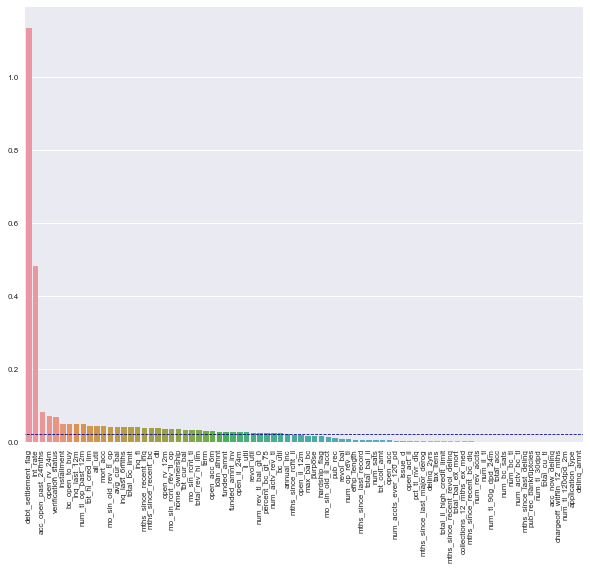

In [7]:
sorted_feature_ivs = sorted(feature_ivs.items(), key=lambda x: x[1], reverse=True)
IV_thresh = 0.02

x = [i[0] for i in sorted_feature_ivs]
y = [i[1] for i in sorted_feature_ivs]
plt.figure(figsize=(10, 8))
sns.set(font_scale=0.8)
sns.barplot(x, y)
plt.hlines(IV_thresh, -1, len(x), linestyles="dashed", linewidth=0.8, colors="navy")
plt.xticks(rotation=90)
# plt.savefig("feature_IV.pdf")
plt.show()

# 多变量分析

## 相关系数矩阵  
只有IV值大于0.02的变量才进行了woe编码，所以保留变量名中包含"woe"的即可

In [8]:
# df_woe.loc[:, df_woe.columns.str.contains("woe|loan_status", regex=True)]
df_for_corr = df_woe.loc[:, df_woe.columns.str.contains("woe")]
df_corr = df_for_corr.corr()

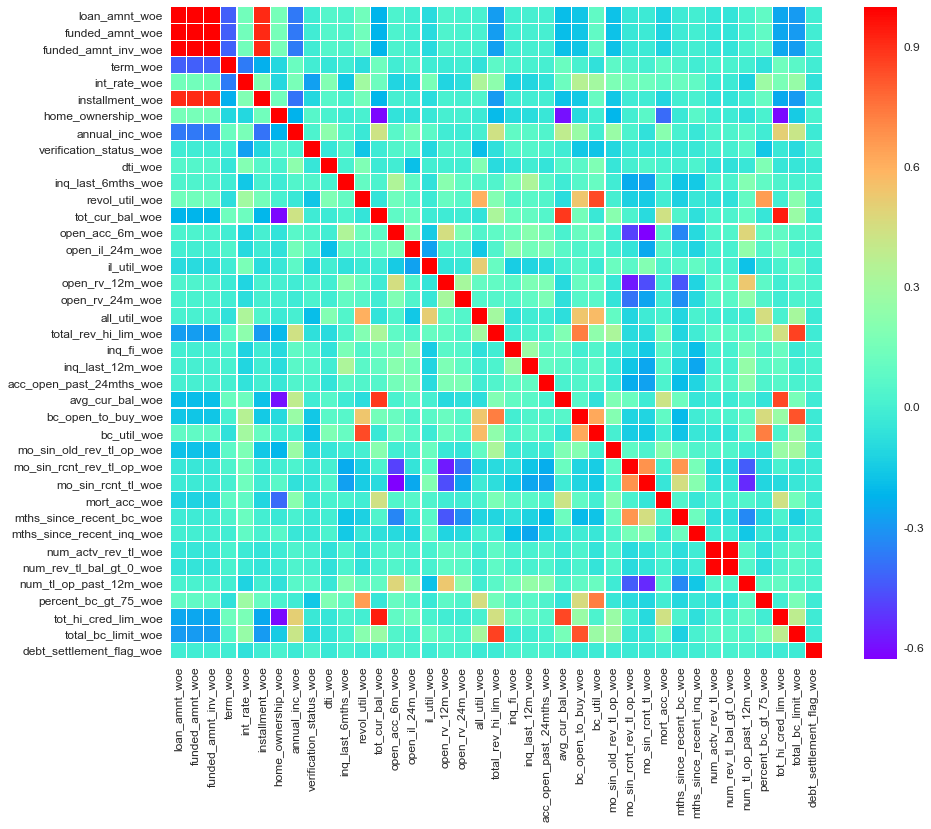

In [9]:
plt.figure(figsize=(15, 12))
sns.set(font_scale=1.2)
sns.heatmap(df_corr, cmap="rainbow", linewidths=0.1, square=True)
# plt.savefig("WOE.heatmap.pdf")
plt.show()

找到相关系数绝对值大于0.6的变量

In [10]:
df_corr[df_corr.abs() > 0.6]

,loan_amnt_woe,funded_amnt_woe,funded_amnt_inv_woe,term_woe,int_rate_woe,installment_woe,home_ownership_woe,annual_inc_woe,verification_status_woe,dti_woe,...,mort_acc_woe,mths_since_recent_bc_woe,mths_since_recent_inq_woe,num_actv_rev_tl_woe,num_rev_tl_bal_gt_0_woe,num_tl_op_past_12m_woe,percent_bc_gt_75_woe,tot_hi_cred_lim_woe,total_bc_limit_woe,debt_settlement_flag_woe
loan_amnt_woe,1.00000,1.00000,0.99655,nan,nan,0.91619,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
funded_amnt_woe,1.00000,1.00000,0.99655,nan,nan,0.91619,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
funded_amnt_inv_woe,0.99655,0.99655,1.00000,nan,nan,0.91333,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
term_woe,nan,nan,nan,1.00000,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
int_rate_woe,nan,nan,nan,nan,1.00000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
installment_woe,0.91619,0.91619,0.91333,nan,nan,1.00000,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
home_ownership_woe,nan,nan,nan,nan,nan,nan,1.00000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,-0.60922,nan,nan
annual_inc_woe,nan,nan,nan,nan,nan,nan,nan,1.00000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
verification_status_woe,nan,nan,nan,nan,nan,nan,nan,nan,1.00000,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
dti_woe,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [11]:
# m = (df_corr.mask(np.eye(len(df_corr), dtype=bool)).abs() > 0.6).any()
# df_corr.loc[m, m]

In [12]:
woe_features = df_corr.columns
corr_dict = {}
for f in woe_features:
    x = df_corr.columns[df_corr.loc[f].abs() > 0.6]
    v = [i for i in x if i != f]
    corr_dict[f] = v

### 相关系数高的变量，保留IV高的哪一个

In [13]:
keeped_features = set()
droped_features = set()
for f, corr_f_list in corr_dict.items():
    if f in droped_features:
        continue
    _f = f.split("_woe")[0]
    if len(corr_f_list)==0:
        keeped_features.add(f)
        continue
    for corr_f in corr_f_list:
        _corr_f = corr_f.split("_woe")[0]
        if feature_ivs[_f] >= feature_ivs[_corr_f]:
            keeped_features.add(f)
            droped_features.add(corr_f)
        else:
            keeped_features.add(corr_f)
            droped_features.add(f)

In [14]:
keeped_features

{'acc_open_past_24mths_woe',
 'all_util_woe',
 'annual_inc_woe',
 'avg_cur_bal_woe',
 'bc_open_to_buy_woe',
 'debt_settlement_flag_woe',
 'dti_woe',
 'home_ownership_woe',
 'il_util_woe',
 'inq_fi_woe',
 'inq_last_12m_woe',
 'inq_last_6mths_woe',
 'installment_woe',
 'int_rate_woe',
 'loan_amnt_woe',
 'mo_sin_old_rev_tl_op_woe',
 'mo_sin_rcnt_rev_tl_op_woe',
 'mo_sin_rcnt_tl_woe',
 'mort_acc_woe',
 'mths_since_recent_bc_woe',
 'mths_since_recent_inq_woe',
 'num_rev_tl_bal_gt_0_woe',
 'num_tl_op_past_12m_woe',
 'open_il_24m_woe',
 'open_rv_12m_woe',
 'open_rv_24m_woe',
 'revol_util_woe',
 'term_woe',
 'tot_hi_cred_lim_woe',
 'total_bc_limit_woe',
 'verification_status_woe'}

In [15]:
keeped_features2 = [i for i in keeped_features if i not in droped_features]
keeped_features2

['inq_last_6mths_woe',
 'mort_acc_woe',
 'inq_fi_woe',
 'num_rev_tl_bal_gt_0_woe',
 'annual_inc_woe',
 'open_rv_12m_woe',
 'int_rate_woe',
 'tot_hi_cred_lim_woe',
 'term_woe',
 'installment_woe',
 'il_util_woe',
 'bc_open_to_buy_woe',
 'open_il_24m_woe',
 'mo_sin_old_rev_tl_op_woe',
 'open_rv_24m_woe',
 'mths_since_recent_bc_woe',
 'mths_since_recent_inq_woe',
 'debt_settlement_flag_woe',
 'dti_woe',
 'verification_status_woe',
 'inq_last_12m_woe',
 'all_util_woe',
 'acc_open_past_24mths_woe',
 'num_tl_op_past_12m_woe']

### debt_settlement_flag_woe IV > 1，属于异常变量，剔除

In [16]:
keeped_features2.remove("debt_settlement_flag_woe")
keeped_features2

['inq_last_6mths_woe',
 'mort_acc_woe',
 'inq_fi_woe',
 'num_rev_tl_bal_gt_0_woe',
 'annual_inc_woe',
 'open_rv_12m_woe',
 'int_rate_woe',
 'tot_hi_cred_lim_woe',
 'term_woe',
 'installment_woe',
 'il_util_woe',
 'bc_open_to_buy_woe',
 'open_il_24m_woe',
 'mo_sin_old_rev_tl_op_woe',
 'open_rv_24m_woe',
 'mths_since_recent_bc_woe',
 'mths_since_recent_inq_woe',
 'dti_woe',
 'verification_status_woe',
 'inq_last_12m_woe',
 'all_util_woe',
 'acc_open_past_24mths_woe',
 'num_tl_op_past_12m_woe']

## 多重共线性  
处理单变量间相关系数后，进行VIF分析  
VIF：方差膨胀因子

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [18]:
def design_matrix(df):
    pass


df_keeped = df_woe[keeped_features2]
df_keeped.head(10)

,inq_last_6mths_woe,mort_acc_woe,inq_fi_woe,num_rev_tl_bal_gt_0_woe,annual_inc_woe,open_rv_12m_woe,int_rate_woe,tot_hi_cred_lim_woe,term_woe,installment_woe,...,mo_sin_old_rev_tl_op_woe,open_rv_24m_woe,mths_since_recent_bc_woe,mths_since_recent_inq_woe,dti_woe,verification_status_woe,inq_last_12m_woe,all_util_woe,acc_open_past_24mths_woe,num_tl_op_past_12m_woe
0,0.00000,0.31670,1.00000,-0.01852,0.32430,2.00000,1.92411,0.26199,0.11106,-0.06883,...,0.30678,2.00000,-0.12144,0.19103,0.20166,0.08665,0.00000,0.26925,4.00000,2.00000
1,0.00000,2.00000,1.00000,0.25979,-0.14807,0.00000,0.08315,-0.19179,0.15453,0.11389,...,0.30678,1.00000,0.06978,0.19103,0.20166,0.08665,0.00000,0.26925,2.00000,0.00000
2,0.00000,1.00000,0.00000,3.00000,-0.06244,0.00000,1.92411,0.10401,0.11106,0.11389,...,-0.11387,0.00000,0.22831,7.04897,-0.05707,0.08665,0.00000,-0.15913,1.00000,0.00000
3,1.00000,0.00000,1.00000,7.00000,0.04899,0.00000,0.58222,-0.07831,0.11106,-0.13914,...,-0.11387,1.00000,-0.05322,0.00000,-0.33436,0.08665,1.00000,0.16122,4.00000,1.00000
4,1.00000,0.00000,3.00000,0.10628,0.15439,4.00000,1.29801,-0.19179,0.11106,0.43431,...,0.30678,-0.41139,-0.05322,2.00000,-0.05707,0.08665,4.00000,0.26925,-0.59012,-0.37562
5,0.00000,1.00000,1.00000,7.00000,0.04899,0.00000,0.38525,0.42877,0.15453,-0.06883,...,0.04289,1.00000,-0.05322,0.19103,0.20166,0.08665,1.00000,-0.20469,5.00000,2.00000
6,0.00000,2.00000,1.00000,7.00000,0.15439,0.00000,-0.26261,0.10401,0.15453,-0.06883,...,0.19978,3.00000,-0.05322,0.19103,0.05485,0.08665,0.00000,-0.15913,4.00000,0.00000
7,0.00000,2.00000,0.00000,0.10628,-0.14807,1.00000,0.08315,-0.19179,0.11106,-0.01959,...,0.19978,3.00000,0.06978,0.19103,0.20166,0.08665,1.00000,0.01133,3.00000,1.00000
8,0.00000,4.00000,4.00000,5.00000,-0.14807,4.00000,0.38525,0.10401,0.11106,0.11389,...,-0.11387,8.00000,-0.12144,0.19103,0.13138,0.12982,7.00000,-0.15913,-0.37070,5.00000
9,1.00000,0.00000,2.00000,0.10628,-0.00704,1.00000,0.98018,-0.19179,0.11106,0.11389,...,-0.20119,2.00000,0.22831,-0.03570,-0.24455,0.08665,2.00000,-0.15913,5.00000,2.00000


In [19]:
df_keeped.insert(0, "beta0", value=np.ones(df_keeped.shape[0]))

In [20]:
vif_series = pd.Series([vif(df_keeped.values, i) for i in range(df_keeped.shape[1])], index=df_keeped.columns)
vif_series

beta0                       97.09903
inq_last_6mths_woe           1.21068
mort_acc_woe                 1.26669
inq_fi_woe                   1.16728
num_rev_tl_bal_gt_0_woe      1.02080
annual_inc_woe               1.93729
open_rv_12m_woe              1.66752
int_rate_woe                 1.91073
tot_hi_cred_lim_woe          1.76509
term_woe                     1.30840
installment_woe              1.39406
il_util_woe                  1.82958
bc_open_to_buy_woe           2.14162
open_il_24m_woe              1.29181
mo_sin_old_rev_tl_op_woe     1.19953
open_rv_24m_woe              1.18033
mths_since_recent_bc_woe     1.44009
mths_since_recent_inq_woe    1.11949
dti_woe                      1.34690
verification_status_woe      1.13222
inq_last_12m_woe             1.27676
all_util_woe                 2.56408
acc_open_past_24mths_woe     1.11135
num_tl_op_past_12m_woe       1.61197
dtype: float64

### 处理VIF > 5的变量

In [21]:
# vif_series[vif_series > 5].index

In [22]:
# print(feature_ivs["loan_amnt"])
# print(feature_ivs["bc_open_to_buy"])
# print(feature_ivs["installment"])
# print(feature_ivs["tot_hi_cred_lim"])

installment的IV值最大，尝试优先处理，可能在剔除造成它VIF过大的某些变量后，其他VIF也得到解决

In [23]:
# rest_features = [f for f in keeped_features if f != "installment_woe"]
# for rm_feature in rest_features:
#     df_rm = df_keeped.drop(columns=rm_feature)
#     vif_series = pd.Series([vif(df_rm.values, i) for i in range(df_rm.shape[1])], index=df_rm.columns)
#     print(f"Now remove {rm_feature}...")
#     print(vif_series)
#     print("\n")

# logistic Regression建模

In [24]:
import statsmodels.discrete.discrete_model as sm
import statsmodels.api as sma

## 建模

In [25]:
y = df_woe["loan_status"]
X = df_keeped

In [26]:
model = sma.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.343216
         Iterations 7


In [27]:
# pd.Series(result.params.values, index=df_keeped.columns)

In [28]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               172052
Model:                          Logit   Df Residuals:                   172028
Method:                           MLE   Df Model:                           23
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                 0.07749
Time:                        14:16:46   Log-Likelihood:                -59051.
converged:                       True   LL-Null:                       -64011.
                                        LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
beta0                        -2.4145      0.072    -33.702      0.000      -2.555      -2.274
inq_last_6mths_woe            0.0824      0.010      8.040      0.000       0.062       0.102
mort_acc_woe                 -0.0348      0.007     -4.868      0.000      -0.049      -0.021
inq_fi_woe                    0.0440      0.006      7.166      0.000       0.032       0.056
num_rev_tl_bal_gt_0_woe       0.0090      0.002      3.766      0.000       0.004       0.014
annual_inc_woe               -0.1115      0.075     -1.493      0.136      -0.258       0.035
open_rv_12m_woe               0.0094      0.007      1.293      0.196      -0.005       0.024
int_rate_woe                 -0.7625      0.015    -50.641      0.000      -0.792      -0.733
tot_hi_cred_lim_woe          -0.6822      0.048    -14.093      0.000      -0.777      -0.587
term_woe                     -0.4528      0.418     -1.083      0.279      -1.272       0.367
installment_woe              -0.8343      0.041    -20.476      0.000      -0.914      -0.754
il_util_woe                  -0.4180      0.062     -6.767      0.000      -0.539      -0.297
bc_open_to_buy_woe           -0.3691      0.051     -7.278      0.000      -0.469      -0.270
open_il_24m_woe               0.0220      0.006      3.603      0.000       0.010       0.034
mo_sin_old_rev_tl_op_woe     -0.3762      0.040     -9.392      0.000      -0.455      -0.298
open_rv_24m_woe               0.0147      0.004      3.707      0.000       0.007       0.022
mths_since_recent_bc_woe     -0.4411      0.048     -9.277      0.000      -0.534      -0.348
mths_since_recent_inq_woe    -0.0120      0.003     -4.113      0.000      -0.018      -0.006
dti_woe                      -0.4519      0.045    -10.040      0.000      -0.540      -0.364
verification_status_woe       2.4672      0.299      8.251      0.000       1.881       3.053
inq_last_12m_woe              0.0101      0.005      2.197      0.028       0.001       0.019
all_util_woe                  0.2230      0.058      3.824      0.000       0.109       0.337
acc_open_past_24mths_woe      0.0060      0.003      2.203      0.028       0.001       0.011
num_tl_op_past_12m_woe        0.0124      0.006      2.138      0.032       0.001       0.024
=============================================================================================
"""

计算woe采用的公式是：  
$woe_{i} = ln(\frac{G_{i}\ /\ G_{total}} {B_{i}\ /\ B_{total}})$  
所以在建模后每个变量的系数应该是负数。  
对系数为正的变量单独建立模型，确定其是否正常

## 处理系数为正的变量

In [29]:
coef_lg_zero_features = (result.params[result.params > 0]).index

for f in coef_lg_zero_features:
    X_ = df_keeped[["beta0", f]]
    model_ = sma.Logit(y, X_)
    result_ = model_.fit()
    print(result_.summary())

Optimization terminated successfully.
         Current function value: 0.370122
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               172052
Model:                          Logit   Df Residuals:                   172050
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                0.005167
Time:                        14:16:50   Log-Likelihood:                -63680.
converged:                       True   LL-Null:                       -64011.
                                        LLR p-value:                7.121e-146
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
beta0                 -2.0900      0.009   -233.794      0.000      -2.107      -2.072
inq_l

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               172052
Model:                          Logit   Df Residuals:                   172050
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                0.002455
Time:                        14:16:53   Log-Likelihood:                -63854.
converged:                       True   LL-Null:                       -64011.
                                        LLR p-value:                 2.509e-70
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
beta0               -2.0869      0.010   -206.766      0.000      -2.107      -2.067
inq_last_12m_woe     0.0735      0.004     18.071      0.000       0.066       0.081
Optimization terminated succ

使用coef > 0的变量单独建模，只有all_util_woe的系数 <0，检查该变量的VIF，2.56，<5，但是确实是所有变量VIF中最大的；  
其他变量可能真的本身存在问题，尝试剔除coef>1的变量，加上all_util_woe，再建模

In [30]:
# neg_features = [f for f in keeped_features2 if f not in coef_lg_zero_features]
neg_features = [f for f in (result.params[result.params < 0]).index]
neg_features = neg_features + ["all_util_woe"]
neg_features

['beta0',
 'mort_acc_woe',
 'annual_inc_woe',
 'int_rate_woe',
 'tot_hi_cred_lim_woe',
 'term_woe',
 'installment_woe',
 'il_util_woe',
 'bc_open_to_buy_woe',
 'mo_sin_old_rev_tl_op_woe',
 'mths_since_recent_bc_woe',
 'mths_since_recent_inq_woe',
 'dti_woe',
 'all_util_woe']

In [31]:
# drop annual_inc_woe
# neg_features.pop(8)

In [32]:
X_neg = df_keeped[neg_features]
model_neg = sma.Logit(y, X_neg)
result_neg = model_neg.fit()
result_neg.summary()

Optimization terminated successfully.
         Current function value: 0.344144
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               172052
Model:                          Logit   Df Residuals:                   172038
Method:                           MLE   Df Model:                           13
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                 0.07499
Time:                        14:16:59   Log-Likelihood:                -59211.
converged:                       True   LL-Null:                       -64011.
                                        LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
beta0                        -1.7253      0.052    -33.399      0.000      -1.827      -1.624
mort_acc_woe                 -0.0307      0.007     -4.297      0.000      -0.045      -0.017
annual_inc_woe                0.1091      0.072      1.508      0.132      -0.033       0.251
int_rate_woe                 -0.8369      0.014    -58.308      0.000      -0.865      -0.809
tot_hi_cred_lim_woe          -0.6373      0.048    -13.227      0.000      -0.732      -0.543
term_woe                     -1.5475      0.411     -3.767      0.000      -2.353      -0.742
installment_woe              -0.7894      0.040    -19.573      0.000      -0.868      -0.710
il_util_woe                  -0.6101      0.059    -10.285      0.000      -0.726      -0.494
bc_open_to_buy_woe           -0.3802      0.050     -7.533      0.000      -0.479      -0.281
mo_sin_old_rev_tl_op_woe     -0.3988      0.040    -10.002      0.000      -0.477      -0.321
mths_since_recent_bc_woe     -0.6108      0.043    -14.203      0.000      -0.695      -0.527
mths_since_recent_inq_woe    -0.0206      0.003     -7.250      0.000      -0.026      -0.015
dti_woe                      -0.5340      0.044    -12.263      0.000      -0.619      -0.449
all_util_woe                  0.3013      0.058      5.232      0.000       0.188       0.414
=============================================================================================
"""

annual_inc_woe和all_util_woe的系数>0，两者之间的相关系数不高，可能存在多重共线性；  
**尝试从模型中分别剔除两个变量再建模**：
注意到annual_inc_woe的p值不显著，所以先剔除

In [33]:
_features = [i for i in neg_features if i != "annual_inc_woe"]

_X = df_keeped[_features]
_model = sma.Logit(y, _X)
_result = _model.fit()
_result.summary()

Optimization terminated successfully.
         Current function value: 0.344151
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               172052
Model:                          Logit   Df Residuals:                   172039
Method:                           MLE   Df Model:                           12
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                 0.07497
Time:                        14:17:13   Log-Likelihood:                -59212.
converged:                       True   LL-Null:                       -64011.
                                        LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
beta0                        -1.7283      0.052    -33.481      0.000      -1.829      -1.627
mort_acc_woe                 -0.0311      0.007     -4.352      0.000      -0.045      -0.017
int_rate_woe                 -0.8350      0.014    -58.389      0.000      -0.863      -0.807
tot_hi_cred_lim_woe          -0.6106      0.045    -13.624      0.000      -0.698      -0.523
term_woe                     -1.5186      0.410     -3.701      0.000      -2.323      -0.714
installment_woe              -0.8065      0.039    -20.824      0.000      -0.882      -0.731
il_util_woe                  -0.5976      0.059    -10.175      0.000      -0.713      -0.483
bc_open_to_buy_woe           -0.3678      0.050     -7.385      0.000      -0.465      -0.270
mo_sin_old_rev_tl_op_woe     -0.3910      0.040     -9.891      0.000      -0.468      -0.314
mths_since_recent_bc_woe     -0.6121      0.043    -14.237      0.000      -0.696      -0.528
mths_since_recent_inq_woe    -0.0208      0.003     -7.326      0.000      -0.026      -0.015
dti_woe                      -0.5105      0.041    -12.561      0.000      -0.590      -0.431
all_util_woe                  0.2832      0.056      5.028      0.000       0.173       0.394
=============================================================================================
"""

all_util_woe依然>0

In [34]:
_features = [i for i in neg_features if i != "all_util_woe"]

_X = df_keeped[_features]
_model = sma.Logit(y, _X)
_result = _model.fit()
_result.summary()

Optimization terminated successfully.
         Current function value: 0.344223
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               172052
Model:                          Logit   Df Residuals:                   172039
Method:                           MLE   Df Model:                           12
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                 0.07478
Time:                        14:17:17   Log-Likelihood:                -59224.
converged:                       True   LL-Null:                       -64011.
                                        LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
beta0                        -1.7217      0.052    -33.339      0.000      -1.823      -1.620
mort_acc_woe                 -0.0301      0.007     -4.225      0.000      -0.044      -0.016
annual_inc_woe                0.0304      0.071      0.430      0.668      -0.108       0.169
int_rate_woe                 -0.8354      0.014    -58.183      0.000      -0.863      -0.807
tot_hi_cred_lim_woe          -0.6476      0.048    -13.450      0.000      -0.742      -0.553
term_woe                     -1.5744      0.411     -3.834      0.000      -2.379      -0.769
installment_woe              -0.7728      0.040    -19.231      0.000      -0.852      -0.694
il_util_woe                  -0.4231      0.047     -8.964      0.000      -0.516      -0.331
bc_open_to_buy_woe           -0.2281      0.041     -5.542      0.000      -0.309      -0.147
mo_sin_old_rev_tl_op_woe     -0.3984      0.040     -9.989      0.000      -0.477      -0.320
mths_since_recent_bc_woe     -0.6194      0.043    -14.405      0.000      -0.704      -0.535
mths_since_recent_inq_woe    -0.0214      0.003     -7.535      0.000      -0.027      -0.016
dti_woe                      -0.4732      0.042    -11.275      0.000      -0.555      -0.391
=============================================================================================
"""

annual_inc_woe依然>0，p值也不显著

对annual_inc单独建模

In [35]:
X_single = df_keeped[["beta0", "annual_inc_woe"]]
model_single = sma.Logit(y, X_single)
result_single = model_single.fit()
result_single.summary()

Optimization terminated successfully.
         Current function value: 0.370989
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               172052
Model:                          Logit   Df Residuals:                   172050
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                0.002836
Time:                        14:17:21   Log-Likelihood:                -63829.
converged:                       True   LL-Null:                       -64011.
                                        LLR p-value:                 5.920e-81
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
beta0             -1.9682      0.007   -267.059      0.000      -1.983      -1.954
annual_inc_woe    -1.0000      0.054    -18.648      0.000      -1.105      -0.895
==================================================================================
"""

单独建模是正常的，说明可能是共线性引起的问题，而且：  
和all_util单独建模的时候两者系数一致。  
**TODO!!!**

# 测试集预测  
**先把all_util和annual_inc两个变量放一放，继续进行后面的工作**

In [36]:
df_test.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
173389,12000.00000,12000.00000,12000.00000,36 months,7.97000,375.88000,10.00000,OWN,42000.00000,Source Verified,...,100.00000,0.00000,1.00000,0.00000,57180.00000,30502.00000,15500.00000,26180.00000,N,N
173390,16000.00000,16000.00000,16000.00000,36 months,7.97000,501.17000,5.00000,RENT,79077.00000,Not Verified,...,78.90000,100.00000,0.00000,0.00000,125018.00000,128572.00000,3700.00000,96918.00000,N,N
173391,33000.00000,33000.00000,33000.00000,36 months,7.21000,1022.12000,0.00000,MORTGAGE,107000.00000,Verified,...,100.00000,0.00000,0.00000,0.00000,404510.00000,48219.00000,81700.00000,73015.00000,N,N
173392,32000.00000,32000.00000,32000.00000,36 months,11.99000,1062.71000,10.00000,MORTGAGE,155000.00000,Source Verified,...,94.90000,0.00000,0.00000,0.00000,527034.00000,63891.00000,124200.00000,20034.00000,N,N
173393,40000.00000,40000.00000,40000.00000,60 months,15.05000,952.65000,9.00000,MORTGAGE,120000.00000,Verified,...,100.00000,0.00000,0.00000,0.00000,367745.00000,154261.00000,64600.00000,168145.00000,N,N
173394,7000.00000,7000.00000,7000.00000,36 months,7.97000,219.26000,10.00000,RENT,32000.00000,Source Verified,...,100.00000,0.00000,1.00000,0.00000,33900.00000,7736.00000,18000.00000,0.00000,N,N
173395,16000.00000,16000.00000,16000.00000,60 months,14.08000,372.96000,5.00000,MORTGAGE,120000.00000,Source Verified,...,100.00000,50.00000,1.00000,0.00000,402500.00000,22288.00000,20300.00000,7500.00000,N,N
173396,15000.00000,15000.00000,15000.00000,60 months,15.05000,357.25000,10.00000,MORTGAGE,90000.00000,Not Verified,...,53.30000,100.00000,0.00000,0.00000,1203529.00000,494291.00000,10300.00000,319853.00000,N,N
173397,22400.00000,22400.00000,22400.00000,60 months,16.02000,544.97000,1.00000,MORTGAGE,216000.00000,Source Verified,...,100.00000,75.00000,0.00000,0.00000,661188.00000,108388.00000,66000.00000,73088.00000,N,N
173398,35000.00000,35000.00000,35000.00000,60 months,12.62000,789.57000,10.00000,MORTGAGE,85000.00000,Source Verified,...,92.30000,25.00000,1.00000,0.00000,40953.00000,21567.00000,18500.00000,21253.00000,N,N


## 最终入模变量

In [37]:
neg_features

['beta0',
 'mort_acc_woe',
 'annual_inc_woe',
 'int_rate_woe',
 'tot_hi_cred_lim_woe',
 'term_woe',
 'installment_woe',
 'il_util_woe',
 'bc_open_to_buy_woe',
 'mo_sin_old_rev_tl_op_woe',
 'mths_since_recent_bc_woe',
 'mths_since_recent_inq_woe',
 'dti_woe',
 'all_util_woe']

**11个变量进入模型**

In [38]:
model_features = [
    'mo_sin_old_rev_tl_op_woe',
    'int_rate_woe',
    'installment_woe',
    'mths_since_recent_inq_woe',
    'mort_acc_woe',
    'mths_since_recent_bc_woe',
    'bc_open_to_buy_woe',
    'il_util_woe',
    'term_woe',
    'tot_hi_cred_lim_woe',
    'dti_woe'
]

## 对测试集进行编码  
**df_eval: woe编码后的测试集数据**

In [39]:
df_eval = pd.DataFrame()
for f in model_features:
    _f = f.split("_woe")[0]
    
    woe_encode_dict = all_features_woe_encode_dict[_f]
    br_encode_dict = all_features_br_encode_dict[_f]
    d_type = ""
    
    if pd.api.types.is_numeric_dtype(df_test[_f].dtype):
        d_type = "number"
        br_encode_dict = None
    else:
        d_type = "object"
    
    df_eval[f] = df_test[_f].apply(
        lambda x: woe_encode(x, woe_encode_dict, d_type=d_type, br_encode_dict=br_encode_dict)
    )

In [40]:
df_eval.head(10)

,mo_sin_old_rev_tl_op_woe,int_rate_woe,installment_woe,mths_since_recent_inq_woe,mort_acc_woe,mths_since_recent_bc_woe,bc_open_to_buy_woe,il_util_woe,term_woe,tot_hi_cred_lim_woe,dti_woe
173389,0.19978,0.98018,-0.06883,0.19103,0.00000,-0.05322,0.00319,-0.07851,0.11106,-0.19179,-0.24455
173390,0.10277,0.98018,-0.13914,7.04897,0.00000,0.52959,-0.21118,0.05133,0.11106,-0.07831,0.13138
173391,-0.11387,1.29801,-0.21232,0.19103,2.00000,-0.12144,0.56986,0.26966,0.11106,0.28440,-0.05707
173392,0.04289,0.22760,-0.21232,-0.31334,0.17979,-0.34939,0.75046,-0.07851,0.11106,0.28440,0.20166
173393,0.10277,-0.26261,-0.21232,0.19103,4.00000,0.06978,0.56986,0.26966,0.15453,0.28440,-0.33436
173394,0.04289,0.98018,0.22701,-0.31334,0.00000,-0.05322,0.00319,0.05133,0.11106,-0.19179,0.20166
173395,0.19978,-0.12474,-0.06883,-0.03570,0.17979,-0.34939,-0.09637,0.26966,0.15453,0.28440,0.20166
173396,0.30678,-0.26261,-0.06883,-0.03570,1.00000,-0.05322,-0.14112,-0.18539,0.15453,0.60936,0.13138
173397,0.30678,-0.37280,-0.13914,-0.03570,1.00000,0.06978,0.00319,0.05133,0.15453,0.42877,-0.05707
173398,0.19978,0.08315,-0.19222,0.19103,2.00000,-0.05322,0.00319,-0.07851,0.15453,-0.19179,0.20166


## 训练模型，做出预测

In [41]:
X_train = df_woe[model_features]
X_train.insert(0, "intercept", np.ones(df_woe.shape[0]))
y_train = df_woe["loan_status"]

model = sma.Logit(y_train, X_train)
fitted_ml = model.fit()
fitted_ml.summary()

Optimization terminated successfully.
         Current function value: 0.344224
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               172052
Model:                          Logit   Df Residuals:                   172040
Method:                           MLE   Df Model:                           11
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                 0.07478
Time:                        14:17:52   Log-Likelihood:                -59224.
converged:                       True   LL-Null:                       -64011.
                                        LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    -1.7226      0.052    -33.386      0.000      -1.824      -1.622
mo_sin_old_rev_tl_op_woe     -0.3961      0.040    -10.021      0.000      -0.474      -0.319
int_rate_woe                 -0.8348      0.014    -58.347      0.000      -0.863      -0.807
installment_woe              -0.7781      0.038    -20.328      0.000      -0.853      -0.703
mths_since_recent_inq_woe    -0.0214      0.003     -7.554      0.000      -0.027      -0.016
mort_acc_woe                 -0.0303      0.007     -4.244      0.000      -0.044      -0.016
mths_since_recent_bc_woe     -0.6197      0.043    -14.412      0.000      -0.704      -0.535
bc_open_to_buy_woe           -0.2271      0.041     -5.527      0.000      -0.308      -0.147
il_util_woe                  -0.4228      0.047     -8.958      0.000      -0.515      -0.330
term_woe                     -1.5655      0.410     -3.817      0.000      -2.369      -0.762
tot_hi_cred_lim_woe          -0.6397      0.044    -14.398      0.000      -0.727      -0.553
dti_woe                      -0.4674      0.040    -11.761      0.000      -0.545      -0.390
=============================================================================================
"""

In [42]:
X_test = df_eval
X_test.insert(0, "intercept", np.ones(df_eval.shape[0]))
y_test_pred = fitted_ml.predict(X_test)

## 模型评价  
包括AUC和KS

### ROC曲线和AUC

In [43]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

In [44]:
y_test = df_test["loan_status"]
auc = roc_auc_score(y_test, y_test_pred)
auc

0.702664617734222

auc 0.7左右，结果还不错

In [45]:
# y_test_pred_class = [(1 if i > 0.23 else 0) for i in y_test_pred]
# sum(y_test_pred_class)
# confusion_matrix(y_test_pred_class, y_test)

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

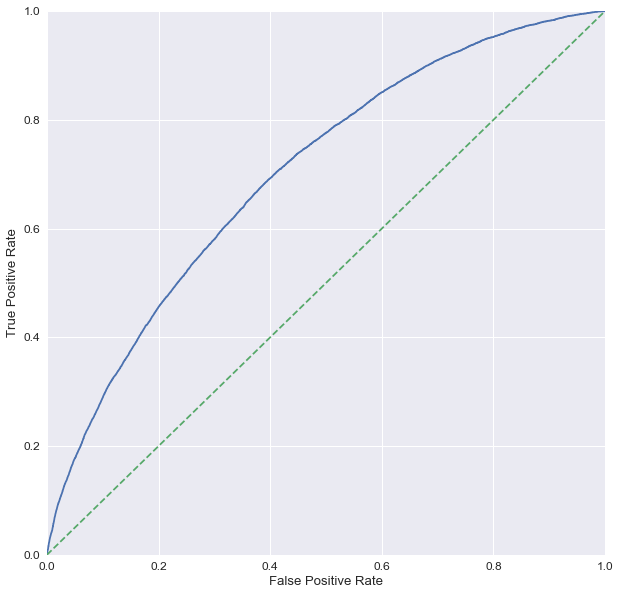

In [47]:
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### KS曲线 

In [48]:
df_cum = calc_ks(y_test, y_test_pred)

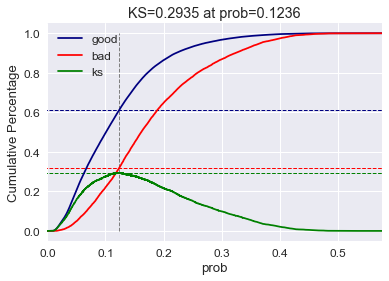

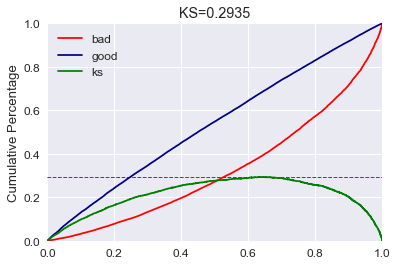

In [49]:
plot_ks(df_cum)
plot_ks2(fpr, tpr)

In [50]:
df_cum["ks"].max()

0.2935201438297335

KS值为0.293，>0.2，接近0.3，应该算一个较好的结果